# **Mounting google drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# **Importing libraries**

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import timeit
import hashlib
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import dump_svmlight_file
import lightgbm as lgb
from sklearn.metrics import ndcg_score
import plotly.graph_objects as go


pd.set_option('display.max_columns', None)

In [ ]:
# Load dataset with tqdm progress bar
with tqdm(total=1, desc="Loading dataset") as pbar:
   df2 = pd.read_csv('/content/drive/MyDrive/Expedia/Data/main.tsv.gz', compression='gzip', sep='\t', nrows=100000)
  # df2 = pd.read_parquet('/content/drive/My Drive/dataset/expedia/exploded_df_100Krows.parquet', engine='pyarrow', columns=None)
   pbar.update(1)

print("Dataset loaded successfully!")
df=df2.copy()

Loading dataset: 100%|██████████| 1/1 [00:08<00:00,  8.08s/it]

Dataset loaded successfully!


In [ ]:
#df = pd.read_csv('/content/drive/MyDrive/Expedia/Data/main.tsv.gz', compression='gzip', sep='\t', nrows=100000)
#exploded_df=pd.read_parquet('/content/drive/My Drive/dataset/expedia/exploded_df_100Krows.parquet')


#EXPLODING AND CONCATENATING FEATURES

Converting search id and user id from strings to unique ids

# Function to convert string to integer ID
def convert_to_int_id(string):
    # Convert string to bytes and hash it using MD5
    hash_object = hashlib.md5(string.encode())
    # Convert hexadecimal digest to integer
    int_id = int(hash_object.hexdigest(), 16)
    return int_id


df['search_id'] = pd.factorize(df['search_id'].apply(convert_to_int_id))[0]
df['user_id'] = pd.factorize(df['user_id'].apply(convert_to_int_id))[0]



In [ ]:
# Function to convert string to integer ID
def convert_to_int_id(string):
    # Convert string to bytes and hash it using MD5
    hash_object = hashlib.md5(string.encode())
    # Convert hexadecimal digest to integer
    int_id = int(hash_object.hexdigest(), 16)
    return int_id


df['search_id'] = pd.factorize(df['search_id'].apply(convert_to_int_id))[0]
df['user_id'] = pd.factorize(df['user_id'].apply(convert_to_int_id))[0]

In [ ]:
df.columns

Index(['user_id', 'search_id', 'search_timestamp', 'point_of_sale',
       'geo_location_country', 'is_mobile', 'destination_id', 'checkin_date',
       'checkout_date', 'adult_count', 'child_count', 'infant_count',
       'room_count', 'sort_type', 'applied_filters', 'impressions'],
      dtype='object')

# **Introducing new features**

- length of stay (checkout_date-checkin_date)
- booking window (day of year(checkin)-day of year(serch_timestamp))
- search_day_of_week= df['search_timestamp'].dt.dayofweek
- search_hour_of_day= df['search_timestamp'].dt.hour

In [ ]:
df['length_of_stay']=(pd.to_datetime(df['checkout_date'])-pd.to_datetime(df['checkin_date'])).dt.days
df['booking_window'] = ((pd.to_datetime(df['checkin_date'], utc=True))  - pd.to_datetime(df['search_timestamp'], utc=True)).dt.days
df['booking_window'] = df['booking_window'].apply(lambda x: 0 if x < 0 else x) # ensures that all negative values in the 'booking_window' column are set to 0.
df.dropna(subset=['booking_window', 'checkin_date', 'checkout_date'], inplace=True)# drop queries where no information on checkin_date and checkout_date
df['search_timestamp']=pd.to_datetime(df['search_timestamp'])
df['search_day_of_week'], df['search_hour_of_day']=df['search_timestamp'].dt.dayofweek, df['search_timestamp'].dt.hour
df['checkin_day']=pd.to_datetime(df['checkin_date']).dt.dayofweek
df['checkout_day']=pd.to_datetime(df['checkin_date']).dt.dayofweek



# Adding feature whether stay_day is weekday or weekend, not working correctly right now

In [ ]:
'''
# Calculate the number of days of stay and limit it from 1 to 7
stay_days = ((df['checkout_date'] - df['checkin_date']).dt.days % 7) + 1

# Create a new column indicating whether each day is a weekday (1 to 5) or a weekend (6 or 7)
df['stay_day_of_week'] = (df['checkin_date'] + pd.to_timedelta(stay_days - 1, 'D')).dt.dayofweek + 1
df['stay_day_of_week'] = df['stay_day_of_week'].apply(lambda x: 'weekend' if x >= 6 else 'weekday')

# Create a mask for weekend days
weekend_mask = (df['checkin_date'].dt.dayofweek >= 4) & (df['checkout_date'].dt.dayofweek <= 6)

# Create a new column indicating whether each day is a weekday or weekend
df['stay_day_of_week'] = 'weekday'  # Initially set all as weekdays
df.loc[weekend_mask, 'stay_day_of_week'] = 'weekend'  # Set weekend days based on the mask
'''

"\n# Calculate the number of days of stay and limit it from 1 to 7\nstay_days = ((df['checkout_date'] - df['checkin_date']).dt.days % 7) + 1\n\n# Create a new column indicating whether each day is a weekday (1 to 5) or a weekend (6 or 7)\ndf['stay_day_of_week'] = (df['checkin_date'] + pd.to_timedelta(stay_days - 1, 'D')).dt.dayofweek + 1\ndf['stay_day_of_week'] = df['stay_day_of_week'].apply(lambda x: 'weekend' if x >= 6 else 'weekday')\n\n# Create a mask for weekend days\nweekend_mask = (df['checkin_date'].dt.dayofweek >= 4) & (df['checkout_date'].dt.dayofweek <= 6)\n\n# Create a new column indicating whether each day is a weekday or weekend\ndf['stay_day_of_week'] = 'weekday'  # Initially set all as weekdays\ndf.loc[weekend_mask, 'stay_day_of_week'] = 'weekend'  # Set weekend days based on the mask\n"

Let's say we have the following data:

checkin_date: 2021-06-01
checkout_date: 2021-06-05
The expression (df['checkin_date'] + pd.to_timedelta(range((df['checkout_date'] - df['checkin_date']).days), 'D')).dt.dayofweek calculates the day of the week for each day of the stay (from check-in to check-out) in the given date range.

Here's how it works step by step:

Calculate the duration of the stay: (df['checkout_date'] - df['checkin_date']).days, which gives us 4 days (from June 1st to June 5th, inclusive).
Generate a range of timedelta objects for each day of the stay: range(4) gives us [0, 1, 2, 3].
Add these timedelta objects to the check-in date: df['checkin_date'] + pd.to_timedelta(range(4), 'D') gives us the dates [2021-06-01, 2021-06-02, 2021-06-03, 2021-06-04].
Extract the day of the week for each date: .dt.dayofweek gives us [1, 2, 3, 4], where 0 represents Monday, 1 represents Tuesday, and so on.
So, the final output would be [1, 2, 3, 4], indicating that the stay covers Tuesday, Wednesday, Thursday, and Friday.

In [ ]:
import plotly.express as px

# Assuming 'df' is your DataFrame and 'booking_window' is the column you want to plot
fig = px.histogram(df, x='booking_window', nbins=90, title='Distribution of booking window within 90 days',
                    labels={'booking_window': 'Booking Window (days)'})

fig.update_layout(xaxis=dict(range=[-1, 90]),  # Adjusting range to better fit the data up to 180 days
                  yaxis_title='Frequency')

# Calculate count for same-day bookings (booking_window = 0)
count_same_day = (df['booking_window'] == 0).sum()

# Add annotation for same-day bookings
offset = max(df['booking_window'].value_counts()) * 0.001

fig.add_annotation(x=16, y=3*count_same_day , text=f'Same-day Bookings: {count_same_day}',
                   showarrow=False, font=dict(size=24, color='black', family='Arial, bold'))

fig.update_layout(
    xaxis=dict(
        title='Booking window (days)',
        title_font=dict(size=28, color='black', family='Arial, bold'),
        tickfont=dict(size=24, color='black', family='Arial, bold'),
        dtick=10
    ),
    yaxis=dict(
        title='Number of bookings',
        title_font=dict(size=28, color='black', family='Arial, bold'),
        tickfont=dict(size=24, color='black', family='Arial, bold')
    ),
    title_font=dict(size=32, color='black', family='Arial, bold'),
    bargap=0.1,  # Adjust the gap between bars
    bargroupgap=0.1,  # Adjust the gap between groups of bars
    width=1000,  # Set the width of the figure
    height=600  # Set the height of the figure
)

fig.show()


# **Explode of impression columns**

In [ ]:
from tqdm import tqdm
impression_column_names=['rank','prop_id','is_travel_ad','review_rating','review_count','star_rating','is_free_cancellation', 'is_drr','price_bucket','num_clicks','is_trans']

# Assuming you already have 'df' loaded and 'impression_column_names' defined
base_columns = list(df.columns)
exploded_column_names = base_columns + impression_column_names
exploded_rows = []

for index, row in tqdm(df.iterrows(), total=len(df), desc="Splitting impressions", unit="row"):
    impressions = row['impressions'].split('|')
    for impression in impressions:
        impression_data = impression.split(',')
        full_row_data = list(row.values) + impression_data  # Ensure this concatenates correctly
        if len(full_row_data) != len(exploded_column_names):
            print(f"Data length mismatch at index {index}: expected {len(exploded_column_names)}, got {len(full_row_data)}")
        else:
            exploded_rows.append(full_row_data)

# Only create DataFrame if data lengths match
if exploded_rows and len(exploded_rows[0]) == len(exploded_column_names):
    exploded_df = pd.DataFrame(exploded_rows, columns=exploded_column_names)
else:
    print("Error: Data length mismatch detected, DataFrame not created.")

Splitting impressions: 100%|██████████| 99993/99993 [00:43<00:00, 2297.67row/s]


In [ ]:
exploded_df=exploded_df.drop({'impressions','applied_filters'},axis=1)
#exploded_df=exploded_df.drop('applied_filters',axis=1)
exploded_df.columns

Index(['user_id', 'search_id', 'search_timestamp', 'point_of_sale',
       'geo_location_country', 'is_mobile', 'destination_id', 'checkin_date',
       'checkout_date', 'adult_count', 'child_count', 'infant_count',
       'room_count', 'sort_type', 'length_of_stay', 'booking_window',
       'search_day_of_week', 'search_hour_of_day', 'checkin_day',
       'checkout_day', 'rank', 'prop_id', 'is_travel_ad', 'review_rating',
       'review_count', 'star_rating', 'is_free_cancellation', 'is_drr',
       'price_bucket', 'num_clicks', 'is_trans'],
      dtype='object')

In [ ]:
#exploded_df=pd.toread_csv('/content/drive/My Drive/dataset/expedia/exploded_df_100Krows_AllDestinations__Amenities_NaHandled_17April.csv')
#df3.to_csv('/content/drive/My Drive/dataset/expedia/exploded_df_100Krows_AllDestinations__NoAmenities_NaHandled_17April.csv', index=False)
#df3.to_parquet('/content/drive/My Drive/dataset/expedia/exploded_df_100Krows_AllDestinations_NaHandled_17April.parquet', index=False)
#filtered_exploded_df.to_parquet('/content/drive/My Drive/Expedia/Data/exploded_df_100Krows.parquet', index=False)

#exploded_df=pd.read_parquet('/content/drive/My Drive/Expedia/Data/exploded_df_100Krows.parquet')

#df_test=pd.read_parquet('/content/drive/My Drive/Expedia/Data/exploded_df_100Krows.parquet')

#df7.to_csv('/content/drive/My Drive/dataset/expedia/exploded_df_100Krows_Top500Destinations__LeftJoin_Amenities_NaHandled_17April.csv', index=False)
#df7=pd.read_csv('/content/drive/My Drive/Expedia/Data/exploded_df_100Krows_AllDestinations__LeftJoin_Amenities_NaHandled_17April.csv')


In [ ]:
df7['destination_id'].nunique()



500

In [ ]:
df1=exploded_df.copy()

In [ ]:
df_searchid_grouped = df1.groupby('search_id', as_index=False).agg({'num_clicks':'sum', 'is_trans':'sum'})

searchid_tokeep = df_searchid_grouped[df_searchid_grouped['num_clicks'] != 0]['search_id'].tolist()  #filters out rows in df_m where the sum of 'num_clicks' isn't zero, then extracts the corresponding 'search_id' values into a list.
df1 = df1[df1['search_id'].isin(searchid_tokeep)]

condition = df1['rank'].astype(int) > 30
df1 = df1[~condition]

In [ ]:
# Grouping the DataFrame by 'search_id' and filtering out groups with only one row
df1 = df1.groupby('search_id').filter(lambda x: len(x) > 1)

In [ ]:
df1['search_id'].nunique()

93019

In [ ]:
columns_converted = ['rank', 'is_travel_ad', 'review_rating', 'review_count', 'star_rating',
                     'is_free_cancellation', 'is_drr', 'price_bucket', 'num_clicks', 'is_trans']

# Define data types for each column
data_types = {
    'rank': int,
    'is_travel_ad': bool,
    'review_rating': float,
    'review_count': int,
    'star_rating': float,
    'is_free_cancellation': bool,
    'is_drr': bool,
    'price_bucket': int,
    'num_clicks': int,
    'is_trans': bool
}

# Use tqdm to track progress across columns
for column in tqdm(columns_converted, desc="Converting columns"):
    df1[column] = df1[column].astype(data_types[column])



Converting columns:  30%|███       | 3/10 [00:00<00:00, 17.04it/s]


IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

In [ ]:
columns_converted = ['rank', 'is_travel_ad', 'review_rating', 'review_count', 'star_rating',
                     'is_free_cancellation', 'is_drr', 'price_bucket', 'num_clicks', 'is_trans']

# Use tqdm to track progress across columns
for column in tqdm(columns_converted, desc="Converting columns"):
    df1[column] = pd.to_numeric(df1[column], errors='coerce')


Converting columns: 100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


In [ ]:
df1.shape

(2574386, 31)

In [ ]:
searchid_withtrans_nobooking = df1[((df1['is_trans'] > 0) & (df1['num_clicks'] == 0))]['search_id'].tolist()
# Filter 'df1' to remove rows with 'search_id's in 'searchid_withtrans_nobooking'
df1 = df1[~df1['search_id'].isin(searchid_withtrans_nobooking)]
'''
print(filtered_df1['search_id'].nunique())
print(df1['search_id'].nunique())
'''

'''
# Calculate counts of each unique 'search_id'
valid_search_ids = df1['search_id'].value_counts()[lambda x: x > 1].index

# Filter DataFrame to keep only rows with 'search_id's that appear more than once
df1 = df1[df1['search_id'].isin(valid_search_ids)]
'''

"\n# Calculate counts of each unique 'search_id'\nvalid_search_ids = df1['search_id'].value_counts()[lambda x: x > 1].index\n\n# Filter DataFrame to keep only rows with 'search_id's that appear more than once\ndf1 = df1[df1['search_id'].isin(valid_search_ids)]\n"

In [ ]:
df1['search_id'].nunique()

92342

In [ ]:
df_m3 = df1[df1['is_travel_ad'] == 0].copy()

df_m3['rank_noad'] = df_m3.groupby('search_id').cumcount()+1

for i, j in tqdm(df1.iterrows(), total=len(df1)):
  if i in df_m3.index:
    df1.at[i,'rank_noad'] = int(df_m3.at[i,'rank_noad'])
  else:
    df1.at[i,'rank_noad'] = int(0)

df1.shape

100%|██████████| 2555148/2555148 [03:54<00:00, 10901.16it/s]


(2555148, 32)

In [ ]:
df_amenities = pd.read_csv('/content/drive/MyDrive/Expedia/Data/amenities.tsv.gz', compression='gzip', sep='\t')
df_amenities['prop_id'] = df_amenities['prop_id'].astype(str)

In [ ]:
# Convert all columns except 'prop_id' to boolean dtype
df_amenities.iloc[:, 1:] = df_amenities.iloc[:, 1:].astype(bool)

# Replace True/False values with 'True'/'False'
df_amenities.iloc[:, 1:] = df_amenities.iloc[:, 1:].replace({True: 'True', False: 'False'})

In [ ]:
amenities_columns=dict(df_amenities.dtypes)
amenities_columns

{'prop_id': dtype('O'),
 'AirConditioning': dtype('O'),
 'AirportTransfer': dtype('O'),
 'Bar': dtype('O'),
 'FreeAirportTransportation': dtype('O'),
 'FreeBreakfast': dtype('O'),
 'FreeParking': dtype('O'),
 'FreeWiFi': dtype('O'),
 'Gym': dtype('O'),
 'HighSpeedInternet': dtype('O'),
 'HotTub': dtype('O'),
 'LaundryFacility': dtype('O'),
 'Parking': dtype('O'),
 'PetsAllowed': dtype('O'),
 'PrivatePool': dtype('O'),
 'SpaServices': dtype('O'),
 'SwimmingPool': dtype('O'),
 'WasherDryer': dtype('O'),
 'WiFi': dtype('O')}

In [ ]:
df_amenities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1496803 entries, 0 to 1496802
Data columns (total 19 columns):
 #   Column                     Non-Null Count    Dtype 
---  ------                     --------------    ----- 
 0   prop_id                    1496803 non-null  object
 1   AirConditioning            1496803 non-null  object
 2   AirportTransfer            1496803 non-null  object
 3   Bar                        1496803 non-null  object
 4   FreeAirportTransportation  1496803 non-null  object
 5   FreeBreakfast              1496803 non-null  object
 6   FreeParking                1496803 non-null  object
 7   FreeWiFi                   1496803 non-null  object
 8   Gym                        1496803 non-null  object
 9   HighSpeedInternet          1496803 non-null  object
 10  HotTub                     1496803 non-null  object
 11  LaundryFacility            1496803 non-null  object
 12  Parking                    1496803 non-null  object
 13  PetsAllowed                

In [ ]:
exploded_df_merged = df1.drop(columns=['search_timestamp'], axis=1).merge(df_amenities, on='prop_id', how='left')


In [ ]:
exploded_df_merged.shape

(2555148, 49)

In [ ]:
exploded_df_merged.isna().sum()

user_id                           0
search_id                         0
point_of_sale                     0
geo_location_country              0
is_mobile                         0
destination_id                    0
checkin_date                      0
checkout_date                     0
adult_count                       0
child_count                       0
infant_count                      0
room_count                        0
sort_type                         0
length_of_stay                    0
booking_window                    0
search_day_of_week                0
search_hour_of_day                0
checkin_day                       0
checkout_day                      0
rank                              0
prop_id                           0
is_travel_ad                      0
review_rating                   239
review_count                    239
star_rating                  394289
is_free_cancellation              0
is_drr                            0
price_bucket                

In [ ]:
for col in df_amenities.columns:
    if col in exploded_df_merged.columns:
        exploded_df_merged[col].fillna(0, inplace=True)


In [ ]:
exploded_df_merged.shape

(2555148, 49)

In [ ]:
df2=exploded_df_merged.copy()

In [ ]:
# Clip values of 'star_rating' column to a range of 0 to 5
df2['star_rating'] = df2['star_rating'].clip(upper=5)
# Convert 'review_count' to numeric type
df2['review_count'] = pd.to_numeric(df2['review_count'], errors='coerce')

# Drop rows where 'review_count' is NA
df2.dropna(subset=['review_count'], inplace=True)

# Fill NA values based on conditions
df2.loc[df2['review_count'] == 0, 'star_rating'] = df2.loc[df2['review_count'] == 0, 'star_rating'].fillna('Not Available')
df2.loc[(df2['review_count'] > 0) & (df2['star_rating'].isna()), 'star_rating'] = 0

print(exploded_df_merged[['star_rating']].value_counts(dropna=False))
print(df2[['star_rating']].value_counts(dropna=False))

star_rating
3.0            849475
4.0            818698
NaN            394289
5.0            295998
2.0            192391
1.0              3818
0.0               467
6.0                12
Name: count, dtype: int64
star_rating  
3.0              849421
4.0              818651
5.0              296010
0                257822
2.0              192380
Not Available    136808
1.0                3817
Name: count, dtype: int64


In [ ]:
df2.shape

(2554909, 49)

In [ ]:
df3=df2.copy()


In [ ]:
df_amenities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1496803 entries, 0 to 1496802
Data columns (total 19 columns):
 #   Column                     Non-Null Count    Dtype 
---  ------                     --------------    ----- 
 0   prop_id                    1496803 non-null  object
 1   AirConditioning            1496803 non-null  int64 
 2   AirportTransfer            1496803 non-null  int64 
 3   Bar                        1496803 non-null  int64 
 4   FreeAirportTransportation  1496803 non-null  int64 
 5   FreeBreakfast              1496803 non-null  int64 
 6   FreeParking                1496803 non-null  int64 
 7   FreeWiFi                   1496803 non-null  int64 
 8   Gym                        1496803 non-null  int64 
 9   HighSpeedInternet          1496803 non-null  int64 
 10  HotTub                     1496803 non-null  int64 
 11  LaundryFacility            1496803 non-null  int64 
 12  Parking                    1496803 non-null  int64 
 13  PetsAllowed                

In [ ]:
# Fill NA values based on conditions
df3.loc[df3['review_count'] == 0, 'review_rating'] = df3.loc[df3['review_count'] == 0, 'review_rating'].fillna('Not Available')
df3.loc[(df3['review_count'] > 0) & (df3['review_rating'].isna()), 'review_rating'] = 0
print(exploded_df_merged[['review_rating']].value_counts(dropna=False))
print(df3[['review_rating']].value_counts(dropna=False))

review_rating
4.0              1414485
5.0               731066
0.0               226830
3.0               162442
2.0                16493
1.0                 3593
NaN                  239
Name: count, dtype: int64
review_rating
4.0              1414485
5.0               731066
0.0               226830
3.0               162442
2.0                16493
1.0                 3593
Name: count, dtype: int64


In [ ]:
df4=df3.copy()

In [ ]:
'''
df3.loc[df3['review_count'] == 0, 'price_bucket'] = df3.loc[df3['review_count'] == 0, 'price_bucket'].fillna('Not Available')
df3.loc[(df3['review_count'] > 0) & (df3['price_bucket'].isna()), 'price_bucket'] = 0
print(exploded_df_top50dest_searched[['price_bucket']].value_counts(dropna=False))
print(df3[['price_bucket']].value_counts(dropna=False))
'''
df4.dropna(subset=['price_bucket'], inplace=True)


In [ ]:
df4.shape

(2163124, 49)

In [ ]:
df5=df4.copy()

In [ ]:
df_searchid_grouped = df5.groupby('search_id', as_index=False).agg({'num_clicks':'sum', 'is_trans':'sum'})

searchid_tokeep = df_searchid_grouped[df_searchid_grouped['num_clicks'] != 0]['search_id'].tolist()  #filters out rows in df_m where the sum of 'num_clicks' isn't zero, then extracts the corresponding 'search_id' values into a list.
df5 = df5[df5['search_id'].isin(searchid_tokeep)]

condition = df5['rank'].astype(int) > 30
df5 = df5[~condition]

In [ ]:
# Group by search_id and aggregate the sum of num_clicks and count of rows per search_id
df_searchid_grouped = df5.groupby('search_id', as_index=False).agg({'num_clicks':'sum', 'is_trans':'count'})

# Filter search_ids with 0 clicks or just one value
searchids_to_keep = df_searchid_grouped[(df_searchid_grouped['num_clicks'] != 0) & (df_searchid_grouped['is_trans'] > 1)]['search_id'].tolist()

# Filter df5 based on search_ids to keep
df5_filtered = df5[df5['search_id'].isin(searchids_to_keep)]

# Print shape of df5
print("Shape of df5:", df5.shape)

# Print shape of df5_filtered
print("Shape of df5_filtered:", df5_filtered.shape)

Shape of df5: (389675, 49)
Shape of df5_filtered: (389481, 49)


In [ ]:
# Group by destination_id and aggregate using count for 'is_trans' and 'search_id'
destination_stats = df5_filtered.groupby('destination_id').agg({'is_trans': 'sum', 'search_id': 'count'})

# Rename the columns for clarity
destination_stats.rename(columns={'is_trans': 'number_of_bookings', 'search_id': 'number_of_searches'}, inplace=True)

print(destination_stats[:500])

                number_of_bookings  number_of_searches
destination_id                                        
1                                9                 148
2                               96                4178
3                                1                2282
4                                1                2403
5                                2                2779
...                            ...                 ...
505                              1                 206
506                              0                 150
507                              0                 326
508                              0                 103
509                              0                 120

[500 rows x 2 columns]


In [ ]:
destination_stats.sort_values(by='number_of_searches', ascending=False)
top_500_destinations_searched = destination_stats.nlargest(500, 'number_of_searches').index
top_500_destinations_booked = destination_stats.nlargest(500, 'number_of_bookings').index

In [ ]:
exploded_df_top500dest_searched=df5_filtered[df5_filtered['destination_id'].isin(top_500_destinations_searched)]

searchings_per_destination = exploded_df_top500dest_searched.groupby('destination_id').size().reset_index(name='number_of_searches')
searchings_per_destination = searchings_per_destination.set_index('destination_id').sort_values(by='number_of_searches', ascending=False)
print(searchings_per_destination)



                number_of_searches
destination_id                    
7                             4642
2                             4178
14                            3511
5                             2779
13                            2486
...                            ...
303                            150
1386                           150
546                            150
1443                           150
1289                           150

[500 rows x 1 columns]


In [ ]:
exploded_df_top500dest_searched.shape

(209981, 49)

In [ ]:
exploded_df_top500dest_searched.to_csv('/content/drive/My Drive/Expedia/Data/exploded_df_100Krows_Top500Destinations__LeftJoin_Amenities_NaHandled_17April.csv', index=False)

## Add weighted average for review counts and total number of amenities
## Remove prop_id which has appeared only once

In [ ]:
df6=exploded_df_top500dest_searched.copy()

In [ ]:
df6.columns

Index(['user_id', 'search_id', 'point_of_sale', 'geo_location_country',
       'is_mobile', 'destination_id', 'checkin_date', 'checkout_date',
       'adult_count', 'child_count', 'infant_count', 'room_count', 'sort_type',
       'length_of_stay', 'booking_window', 'search_day_of_week',
       'search_hour_of_day', 'checkin_day', 'checkout_day', 'rank', 'prop_id',
       'is_travel_ad', 'review_rating', 'review_count', 'star_rating',
       'is_free_cancellation', 'is_drr', 'price_bucket', 'num_clicks',
       'is_trans', 'rank_noad', 'AirConditioning', 'AirportTransfer', 'Bar',
       'FreeAirportTransportation', 'FreeBreakfast', 'FreeParking', 'FreeWiFi',
       'Gym', 'HighSpeedInternet', 'HotTub', 'LaundryFacility', 'Parking',
       'PetsAllowed', 'PrivatePool', 'SpaServices', 'SwimmingPool',
       'WasherDryer', 'WiFi'],
      dtype='object')

In [ ]:
df6['review_rating'].value_counts()

review_rating
4.0    130496
5.0     55353
3.0     13713
0.0      8984
2.0      1283
1.0       152
Name: count, dtype: int64

In [ ]:
df6.shape

(209981, 49)

In [ ]:
df_amenities.head()

,prop_id,AirConditioning,AirportTransfer,Bar,FreeAirportTransportation,FreeBreakfast,FreeParking,FreeWiFi,Gym,HighSpeedInternet,HotTub,LaundryFacility,Parking,PetsAllowed,PrivatePool,SpaServices,SwimmingPool,WasherDryer,WiFi
0,3,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
1,5,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
2,11,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,16,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
4,23,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0


In [ ]:
grouped_df = df_amenities.groupby('prop_id').sum()

# Calculate the number_of_amenities column as the sum of all other columns
grouped_df['number_of_amenities'] = grouped_df.sum(axis=1)

df7 = pd.merge(df6, grouped_df[['number_of_amenities']], left_on='prop_id', right_index=True, how='left')

In [ ]:
# Replace missing values in 'number_of_amenities' with 0
df7['number_of_amenities'].fillna(0, inplace=True)


In [ ]:
review_rating_counts = df7.groupby('prop_id')['review_rating'].nunique()

# Check if any prop_id has only one unique review_rating
similar_ratings = review_rating_counts[review_rating_counts == 1].index.tolist()

# Check if any prop_id has more than one unique review_rating
distinct_ratings = review_rating_counts[review_rating_counts > 1].index.tolist()

# Print or use the results
#print("Prop IDs with similar review ratings:", similar_ratings)
#print("Prop IDs with distinct review ratings:", distinct_ratings)

# Calculate the length of the list of properties with similar ratings
num_similar_ratings = len(similar_ratings)

# Calculate the length of the list of properties with distinct ratings
num_distinct_ratings = len(distinct_ratings)

# Print or use the results
print("Number of properties with similar ratings:", num_similar_ratings)
print("Number of properties with distinct ratings:", num_distinct_ratings)

Number of properties with similar ratings: 41135
Number of properties with distinct ratings: 619


In [ ]:
df7['destination_id'].nunique()

500

# Implementing prop_id with few review counts as other


In [ ]:
df7['property_appearance_count'] = df7.groupby('prop_id')['prop_id'].transform('count')
# Create the histogram
fig = go.Figure(data=[go.Histogram(x=df7['property_appearance_count'],nbinsx=100)])
# Update layout
fig.update_layout(
    title='Distribution of Property Appearance Count',
    title_font=dict(size=28, color='black', family='Arial, bold'),
    xaxis=dict(
        title='Property Appearance Count',
        title_font=dict(size=24, color='black', family='Arial, bold'),
        tickfont=dict(size=20, color='black', family='Arial, bold'),
        range=[0, 400]  # Adjust the range if needed
    ),
    yaxis=dict(
        title='Frequency',
        title_font=dict(size=24, color='black', family='Arial, bold'),
        tickfont=dict(size=20, color='black', family='Arial, bold')
    )
)

# Show the plot
fig.show()

In [ ]:
review_counts = df7.groupby('prop_id')['review_count'].sum()

# Sort the resulting Series in descending order of review counts
sorted_review_counts = review_counts.sort_values(ascending=False)

# Show the sorted Series
print(sorted_review_counts)

prop_id
4853142    6187925.0
5448913    5380400.0
6987302    4719775.0
6873317    4151050.0
3907993    4031525.0
             ...    
4976063          0.0
2625701          0.0
4976426          0.0
262400           0.0
546145           0.0
Name: review_count, Length: 41754, dtype: float64


In [3]:
df7=pd.read_csv('/content/drive/My Drive/Expedia/Data/exploded_df_100Krows_AllDestinations__LeftJoin_Amenities_NaHandled_17April.csv')

In [4]:
df7.head()

,user_id,search_id,point_of_sale,geo_location_country,is_mobile,destination_id,checkin_date,checkout_date,adult_count,child_count,infant_count,room_count,sort_type,length_of_stay,booking_window,search_day_of_week,search_hour_of_day,checkin_day,checkout_day,rank,prop_id,is_travel_ad,review_rating,review_count,star_rating,is_free_cancellation,is_drr,price_bucket,num_clicks,is_trans,rank_noad,AirConditioning,AirportTransfer,Bar,FreeAirportTransportation,FreeBreakfast,FreeParking,FreeWiFi,Gym,HighSpeedInternet,HotTub,LaundryFacility,Parking,PetsAllowed,PrivatePool,SpaServices,SwimmingPool,WasherDryer,WiFi,number_of_amenities
0,2,2,1,1,0,49,2021-07-07,2021-07-12,2,0,0,1,RECOMMENDED,5.0,26.0,3,0,2,2,1,1624072,0,4.0,1250.0,4.0,1,1,2.0,1,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
1,2,2,1,1,0,49,2021-07-07,2021-07-12,2,0,0,1,RECOMMENDED,5.0,26.0,3,0,2,2,2,5170759,1,4.0,1025.0,3.0,0,0,1.0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,7.0
2,2,2,1,1,0,49,2021-07-07,2021-07-12,2,0,0,1,RECOMMENDED,5.0,26.0,3,0,2,2,3,1342604,1,4.0,1375.0,4.0,1,1,4.0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,9.0
3,2,2,1,1,0,49,2021-07-07,2021-07-12,2,0,0,1,RECOMMENDED,5.0,26.0,3,0,2,2,4,5866319,0,4.0,2225.0,4.0,1,1,1.0,0,0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,6.0
4,2,2,1,1,0,49,2021-07-07,2021-07-12,2,0,0,1,RECOMMENDED,5.0,26.0,3,0,2,2,5,2935403,0,5.0,1050.0,4.0,1,1,2.0,0,0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,6.0


In [52]:
df8=df7.copy()

# **Data types for amenities and impression columns**

In [53]:
main_columns = {
    'qid': int,
    'point_of_sale': 'O',
    'geo_location_country': 'O',
    'is_mobile': bool,
    'destination_id': 'O',
    'adult_count': int,
    'child_count': int,
    'infant_count': int,
    'room_count': int,
    'sort_type': 'O',
    'length_of_stay': int,
    'booking_window': int,
    'search_day_of_week': 'O',
    'search_hour_of_day': 'O',
    'checkin_day': 'O',
    'checkout_day': 'O'
}

impression_columns = {
    'rank': int,
    'is_travel_ad': bool,
    'review_rating': 'O',
    'review_count': int,
    'star_rating': 'O',
    'is_free_cancellation': bool,
    'is_drr': bool,
    'price_bucket': int,
    'num_clicks': int,
    'is_trans': bool
}

amenities_columns = {
    'prop_id': 'O',
    'AirConditioning': bool,
    'AirportTransfer': bool,
    'Bar': bool,
    'FreeAirportTransportation': bool,
    'FreeBreakfast': bool,
    'FreeParking': bool,
    'FreeWiFi': bool,
    'Gym': bool,
    'HighSpeedInternet': bool,
    'HotTub': bool,
    'LaundryFacility': bool,
    'Parking': bool,
    'PetsAllowed': bool,
    'PrivatePool': bool,
    'SpaServices': bool,
    'SwimmingPool': bool,
    'WasherDryer': bool,
    'WiFi': bool
}

features_engineered= {'user_id': 'O',
 'search_id': 'O',
 'checkin_date': 'datetime',
 'checkout_date': 'datetime',
 'rank_noad': int,
 'number_of_amenities': int}

# Given list of all columns
all_columns = df8.columns.tolist()
# Columns present in any of the dictionaries
present_columns = set(list(main_columns.keys()) + list(impression_columns.keys()) + list(amenities_columns.keys()))

# Columns not present in any of the dictionaries
#features_engineered = {column: None for column in all_columns if column not in present_columns}




In [54]:
for column in tqdm(df8.columns, desc="Converting columns"):
    if column in main_columns:
        df8[column] = df8[column].astype(main_columns[column])
    elif column in impression_columns:
        df8[column] = df8[column].astype(impression_columns[column])
    elif column in amenities_columns:
        df8[column] = df8[column].astype(amenities_columns[column])


Converting columns: 100%|██████████| 50/50 [00:00<00:00, 671.35it/s]


In [55]:
df8.rename(columns={'search_id':'qid'}, inplace=True)

df8['relevance'] = df8['num_clicks'] + 2 * df8['is_trans']
df8.loc[df8['relevance'] > 3, 'relevance'] = 3


# **Columns to be dropped**

Columns to be not dropped are '#' or commented

In [56]:
main_columns_dropped = {
    #'qid': int, # to be dropped after train, test split
    'point_of_sale': 'O',
    'geo_location_country': 'O',
    #'is_mobile': bool,
    #'destination_id': 'O',
    #'adult_count': int,
    #'child_count': int,
    #'infant_count': int,
    #'room_count': int,
    'sort_type': 'O',
    'length_of_stay': int,
    'booking_window': int,
    #'search_day_of_week': 'O',
    #'search_hour_of_day': 'O',
    #'checkin_day': 'O',
    #'checkout_day': 'O'
}

impression_columns_dropped = {
    #'rank': int,
    #'is_travel_ad': bool,
    #'review_rating': 'O',
    #'review_count': int,
    #'star_rating': 'O',
    #'is_free_cancellation': bool,
    #'is_drr': bool,
    #'price_bucket': int,
    'num_clicks': int,
    'is_trans': bool
}
amenities_columns_dropped={'prop_id': 'O'}
'''
amenities_columns_dropped = {

    'prop_id': 'O',
    'AirConditioning': bool,
    'AirportTransfer': bool,
    'Bar': bool,
    'FreeAirportTransportation': bool,
    'FreeBreakfast': bool,
    'FreeParking': bool,
    'FreeWiFi': bool,
    'Gym': bool,
    'HighSpeedInternet': bool,
    'HotTub': bool,
    'LaundryFacility': bool,
    'Parking': bool,
    'PetsAllowed': bool,
    'PrivatePool': bool,
    'SpaServices': bool,
    'SwimmingPool': bool,
    'WasherDryer': bool,
    'WiFi': bool

}
'''

features_engineered_dropped= {
    'user_id': 'O',
    'search_id': 'O',
    'checkin_date': 'datetime',
    'checkout_date': 'datetime',
    #'rank_noad': int,
    #'number_of_amenities': int,
    'checkin_day' :int,
    'checkout_day':int,
    #'relevance':int
 }

df8_dropped=df8.copy()

In [57]:
df8_dropped.columns

Index(['user_id', 'qid', 'point_of_sale', 'geo_location_country', 'is_mobile',
       'destination_id', 'checkin_date', 'checkout_date', 'adult_count',
       'child_count', 'infant_count', 'room_count', 'sort_type',
       'length_of_stay', 'booking_window', 'search_day_of_week',
       'search_hour_of_day', 'checkin_day', 'checkout_day', 'rank', 'prop_id',
       'is_travel_ad', 'review_rating', 'review_count', 'star_rating',
       'is_free_cancellation', 'is_drr', 'price_bucket', 'num_clicks',
       'is_trans', 'rank_noad', 'AirConditioning', 'AirportTransfer', 'Bar',
       'FreeAirportTransportation', 'FreeBreakfast', 'FreeParking', 'FreeWiFi',
       'Gym', 'HighSpeedInternet', 'HotTub', 'LaundryFacility', 'Parking',
       'PetsAllowed', 'PrivatePool', 'SpaServices', 'SwimmingPool',
       'WasherDryer', 'WiFi', 'number_of_amenities', 'relevance'],
      dtype='object')

In [58]:

# Define the lists of columns to be dropped
columns_to_drop = {**main_columns_dropped, **impression_columns_dropped,
                   **amenities_columns_dropped, **features_engineered_dropped}

# Loop through each column in df_model and perform conversions
for column in tqdm(df8_dropped.columns, desc="Converting columns"):
    if column in columns_to_drop:
        df8_dropped.drop(column, axis=1, inplace=True)
    elif column in main_columns:
        df8_dropped[column] = df8_dropped[column].astype(main_columns[column])
    elif column in impression_columns:
        df8_dropped[column] = df8_dropped[column].astype(impression_columns[column])
    elif column in amenities_columns:
        df8_dropped[column] = df8_dropped[column].astype(amenities_columns[column])


Converting columns: 100%|██████████| 51/51 [00:00<00:00, 128.78it/s]


# **Numeric and Categoric data handling**

# Train, validation and test split

In [59]:
df8_dropped.shape

(209981, 38)

In [60]:
df_model=df8_dropped.copy()

In [61]:
from sklearn.model_selection import GroupShuffleSplit

# Define the function for splitting based on qids
def split_by_qid(df, test_size):
    gss = GroupShuffleSplit(test_size=test_size, n_splits=1, random_state=42)
    ids = df['qid'].unique()
    train_idx, test_idx = next(gss.split(ids, groups=ids))
    return df[df['qid'].isin(ids[train_idx])], df[df['qid'].isin(ids[test_idx])]

# Perform the splits
train_df, temp_df = split_by_qid(df_model, test_size=0.4)
valid_df, test_df = split_by_qid(temp_df, test_size=0.5)

# Display shapes
train_df.shape, valid_df.shape, test_df.shape

((126060, 38), (42075, 38), (41846, 38))

In [62]:
# Reordering the columns
columns_reordered = ['relevance'] + [col for col in train_df.columns if col != 'relevance']
train_df = train_df[columns_reordered]
valid_df = valid_df[columns_reordered]
test_df = test_df[columns_reordered]
test_df.head()


,relevance,qid,is_mobile,destination_id,adult_count,child_count,infant_count,room_count,search_day_of_week,search_hour_of_day,rank,is_travel_ad,review_rating,review_count,star_rating,is_free_cancellation,is_drr,price_bucket,rank_noad,AirConditioning,AirportTransfer,Bar,FreeAirportTransportation,FreeBreakfast,FreeParking,FreeWiFi,Gym,HighSpeedInternet,HotTub,LaundryFacility,Parking,PetsAllowed,PrivatePool,SpaServices,SwimmingPool,WasherDryer,WiFi,number_of_amenities
0,1,2,False,49,2,0,0,1,3,0,1,False,4.0,1250,4.0,True,True,2,1.0,True,False,False,False,False,False,True,True,True,False,True,False,False,False,False,False,False,False,5.0
1,0,2,False,49,2,0,0,1,3,0,2,True,4.0,1025,3.0,False,False,1,0.0,False,False,True,False,False,False,True,True,True,False,True,True,False,False,False,True,False,False,7.0
2,0,2,False,49,2,0,0,1,3,0,3,True,4.0,1375,4.0,True,True,4,0.0,False,False,True,False,False,False,True,True,True,False,True,True,True,False,False,True,False,True,9.0
3,0,2,False,49,2,0,0,1,3,0,4,False,4.0,2225,4.0,True,True,1,2.0,False,False,True,False,False,False,False,True,False,False,True,True,True,False,False,False,False,True,6.0
4,0,2,False,49,2,0,0,1,3,0,5,False,5.0,1050,4.0,True,True,2,3.0,False,False,True,False,False,False,True,True,False,False,True,True,True,False,False,False,False,False,6.0


In [63]:
X_train = train_df.drop(columns=['relevance'],axis=1)
y_train = train_df['relevance']

X_valid = valid_df.drop(columns=['relevance'],axis=1)
y_valid = valid_df['relevance']

X_test = test_df.drop(columns=['relevance'],axis=1)
y_test = test_df['relevance']

query_id_train = X_train['qid']
query_id_valid = X_valid['qid']
query_id_test = X_test['qid']


# Handling categorical with pd.get_dummies(OHE) and numerical columns with standard scaling

In [64]:
categorical_features = X_train.select_dtypes(include=['object','bool']).columns.tolist()
numerical_features = X_train.select_dtypes(include=['int','float']).columns.tolist()


In [65]:
combined_df=pd.concat([X_train, X_valid, X_test])
combined_df=pd.get_dummies(combined_df, columns=categorical_features)

In [66]:
# Display shapes
#X_train.shape, X_valid.shape, X_test.shape
combined_df.shape

(209981, 598)

In [67]:
X_train=combined_df[:len(X_train)]
X_valid=combined_df[len(X_train): len(X_train)+len(X_valid)]
X_test=combined_df[len(X_train)+len(X_valid):]
X_train.shape, X_test.shape, X_valid.shape

((126060, 598), (41846, 598), (42075, 598))

In [69]:
from tqdm.auto import tqdm
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

In [70]:
X_train_2 = X_train.drop(columns=['qid'])
X_valid_2 = X_valid.drop(columns=['qid'])
X_test_2 = X_test.drop(columns=['qid'])

In [ ]:
X_test.shape

(62937, 14)

In [72]:
scaler=StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_valid[numerical_features] = scaler.transform(X_valid[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

'''
X_train = pd.get_dummies(X_train, columns=categorical_features)
X_valid = pd.get_dummies(X_valid, columns=categorical_features)
X_test = pd.get_dummies(X_test, columns=categorical_features)
'''

<ipython-input-72-555797667730>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
<ipython-input-72-555797667730>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid[numerical_features] = scaler.transform(X_valid[numerical_features])
<ipython-input-72-555797667730>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

'\nX_train = pd.get_dummies(X_train, columns=categorical_features)\nX_valid = pd.get_dummies(X_valid, columns=categorical_features)\nX_test = pd.get_dummies(X_test, columns=categorical_features)\n'

In [73]:
X_train.shape, X_test.shape, X_valid.shape

((126060, 598), (41846, 598), (42075, 598))

In [74]:
X_train.replace({False: 0, True: 1}, inplace=True)
X_train.head()


<ipython-input-74-8cdba78671a0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.replace({False: 0, True: 1}, inplace=True)


,qid,adult_count,child_count,infant_count,room_count,rank,review_count,price_bucket,rank_noad,number_of_amenities,is_mobile_False,is_mobile_True,destination_id_2,destination_id_3,destination_id_4,destination_id_5,destination_id_6,destination_id_7,destination_id_8,destination_id_9,destination_id_10,destination_id_11,destination_id_12,destination_id_13,destination_id_14,destination_id_15,destination_id_16,destination_id_17,destination_id_18,destination_id_19,destination_id_20,destination_id_21,destination_id_22,destination_id_23,destination_id_24,destination_id_25,destination_id_26,destination_id_27,destination_id_28,destination_id_29,destination_id_30,destination_id_31,destination_id_32,destination_id_33,destination_id_34,destination_id_35,destination_id_36,destination_id_37,destination_id_38,destination_id_39,destination_id_40,destination_id_41,destination_id_42,destination_id_43,destination_id_44,destination_id_45,destination_id_46,destination_id_47,destination_id_48,destination_id_49,destination_id_50,destination_id_51,destination_id_52,destination_id_53,destination_id_54,destination_id_55,destination_id_56,destination_id_57,destination_id_58,destination_id_59,destination_id_60,destination_id_61,destination_id_62,destination_id_63,destination_id_64,destination_id_65,destination_id_66,destination_id_67,destination_id_68,destination_id_69,destination_id_70,destination_id_72,destination_id_74,destination_id_75,destination_id_76,destination_id_77,destination_id_78,destination_id_79,destination_id_80,destination_id_81,destination_id_82,destination_id_83,destination_id_84,destination_id_85,destination_id_86,destination_id_87,destination_id_88,destination_id_89,destination_id_90,destination_id_91,destination_id_92,destination_id_94,destination_id_95,destination_id_96,destination_id_97,destination_id_98,destination_id_99,destination_id_100,destination_id_101,destination_id_102,destination_id_103,destination_id_104,destination_id_105,destination_id_106,destination_id_107,destination_id_108,destination_id_109,destination_id_110,destination_id_111,destination_id_112,destination_id_113,destination_id_114,destination_id_115,destination_id_116,destination_id_117,destination_id_118,destination_id_119,destination_id_120,destination_id_121,destination_id_122,destination_id_123,destination_id_124,destination_id_125,destination_id_126,destination_id_127,destination_id_128,destination_id_129,destination_id_131,destination_id_132,destination_id_134,destination_id_135,destination_id_136,destination_id_137,destination_id_138,destination_id_139,destination_id_140,destination_id_142,destination_id_143,destination_id_144,destination_id_147,destination_id_148,destination_id_149,destination_id_151,destination_id_152,destination_id_153,destination_id_154,destination_id_155,destination_id_156,destination_id_157,destination_id_158,destination_id_159,destination_id_160,destination_id_161,destination_id_162,destination_id_163,destination_id_164,destination_id_165,destination_id_166,destination_id_167,destination_id_168,destination_id_169,destination_id_170,destination_id_172,destination_id_173,destination_id_174,destination_id_175,destination_id_176,destination_id_177,destination_id_178,destination_id_179,destination_id_181,destination_id_182,destination_id_183,destination_id_184,destination_id_186,destination_id_187,destination_id_189,destination_id_192,destination_id_194,destination_id_195,destination_id_196,destination_id_198,destination_id_199,destination_id_200,destination_id_201,destination_id_202,destination_id_203,destination_id_205,destination_id_206,destination_id_207,destination_id_208,destination_id_210,destination_id_211,destination_id_212,destination_id_213,destination_id_214,destination_id_215,destination_id_216,destination_id_217,destination_id_218,destination_id_219,destination_id_222,destination_id_223,destination_id_224,destination_id_225,destination_id_226,destination_id_227,destination_id_228,destination_id_229,destination_id_230,destin

In [75]:
import numpy as np
from tqdm import tqdm

# Define function to replace values in DataFrame
def replace_values(df):
    # Convert DataFrame to numpy array
    df_array = df.values

    # Use tqdm to track progress
    for i in tqdm(range(df_array.shape[0]), desc="Replacing values"):
        for j in range(df_array.shape[1]):
            if df_array[i, j] == False:
                df_array[i, j] = 0
            elif df_array[i, j] == True:
                df_array[i, j] = 1

    # Convert numpy array back to DataFrame
    df_result = pd.DataFrame(df_array, columns=df.columns)
    return df_result

# Replace values in X_valid
X_valid = replace_values(X_valid)

# Replace values in X_test
X_test = replace_values(X_test)


Replacing values: 100%|██████████| 41846/41846 [00:07<00:00, 5620.62it/s]


In [39]:
from sklearn.datasets import dump_svmlight_file

# Save X_train as SVMLight file with .txt extension
file_path_train = '/content/drive/My Drive/Expedia/Data/allRank_implementation/train.txt'
dump_svmlight_file(X_train, y_train, f=file_path_train, query_id=query_id_train)

# Save X_valid as SVMLight file with .txt extension
file_path_valid = '/content/drive/My Drive/Expedia/Data/allRank_implementation/valid.txt'
dump_svmlight_file(X_valid, y_valid, f=file_path_valid, query_id=query_id_valid)

# Save X_test as SVMLight file with .txt extension
file_path_test = '/content/drive/My Drive/Expedia/Data/allRank_implementation/test.txt'
dump_svmlight_file(X_test, y_test, f=file_path_test, query_id=query_id_test)

In [ ]:
file_path='/content/drive/My Drive/Expedia/Data/train_allrank.svmlight'
dump_svmlight_file(X_train, y_train, f=file_path, query_id=query_id_train)

file_path = '/content/drive/My Drive/Expedia/Data/test_allrank.svmlight'
dump_svmlight_file(X_test, y_test, f=file_path, query_id=query_id_test)



# **Light GBM Implementation**

In [76]:
import lightgbm as lgb

X_train_arr = X_train_2.values

y_train_array = y_train.values.ravel()

query_group_sizes_train = []
for i in X_train['qid'].value_counts():
  query_group_sizes_train.append(i)

query_group_sizes_train_arr = np.array(query_group_sizes_train)


# Define LightGBM parameters for ranker
params = {
    'objective': 'lambdarank',  # Ranking objective
    'metric': 'ndcg',  # Evaluation metric
    'learning_rate': 0.01,
    'verbose': 0
}


train_data = lgb.Dataset(X_train_arr, label=y_train_array, group=query_group_sizes_train_arr)


num_rounds = 1000
ranker_model = lgb.train(params, train_data, num_rounds)


In [77]:
X_test_2 = X_test.drop(columns=['qid'])
X_test_arr = X_test_2.values

y_test_array = y_test.values.ravel()

query_group_sizes_test = []
for i in X_test['qid'].value_counts():
  query_group_sizes_test.append(i)
query_group_sizes_test_arr = np.array(query_group_sizes_test)

test_data = lgb.Dataset(X_test_arr, label=y_test_array, group=query_group_sizes_test_arr, reference=train_data)


In [ ]:
X_train_arr.shape, X_test_arr.shape

((147044, 57), (62937, 57))

In [78]:
test_predictions = ranker_model.predict(X_test_arr.astype(float))

y_test_df = pd.DataFrame({'relevance_score': y_test, 'predicted_ranking': test_predictions})
y_test_df.head()

test_df['predicted_score'] = test_predictions
y_test_df.shape

(41846, 2)

In [43]:
test_df['relevance'], test_df['predicted_score']

(0         1
 1         0
 2         0
 3         0
 4         0
          ..
 209859    0
 209860    0
 209861    0
 209862    0
 209863    0
 Name: relevance, Length: 41846, dtype: int64,
 0        -0.224173
 1        -0.199838
 2        -0.475806
 3        -0.360197
 4        -0.037951
             ...   
 209859   -0.094389
 209860   -0.470941
 209861   -0.274133
 209862   -0.306160
 209863   -0.416105
 Name: predicted_score, Length: 41846, dtype: float64)

In [79]:
ndcg_per_query = []
for group_name, group_df in test_df.groupby('qid'):
    pred_scores = group_df['predicted_score']
    true_labels = sorted(group_df['relevance'],reverse=True)  # Assuming predicted scores are the same as true labels
    ndcg = ndcg_score([true_labels], [pred_scores])
    ndcg_per_query.append(ndcg)

print('NDCG mean taking into account all values of the ranking', np.mean(ndcg_per_query))

NDCG mean taking into account all values of the ranking 0.29673281962744436


In [81]:
test_predictions = ranker_model.predict(X_test_arr.astype(float))

y_test_df = pd.DataFrame({'relevance_score': y_test, 'predicted ranking': test_predictions})
y_test_df.head()

test_ndcg = ndcg_score([y_test], [test_predictions])
print("Test NDCG Score for All:", test_ndcg)

test_ndcg = ndcg_score([y_test], [test_predictions], k=5)
print("Test NDCG Score 5k:", test_ndcg)

test_ndcg = ndcg_score([y_test], [test_predictions], k=10)
print("Test NDCG Score 10k:", test_ndcg)

test_ndcg = ndcg_score([y_test], [test_predictions], k=20)
print("Test NDCG Score 20k:", test_ndcg)

Test NDCG Score for All: 0.6234418104633814
Test NDCG Score 5k: 0.0
Test NDCG Score 10k: 0.0
Test NDCG Score 20k: 0.0


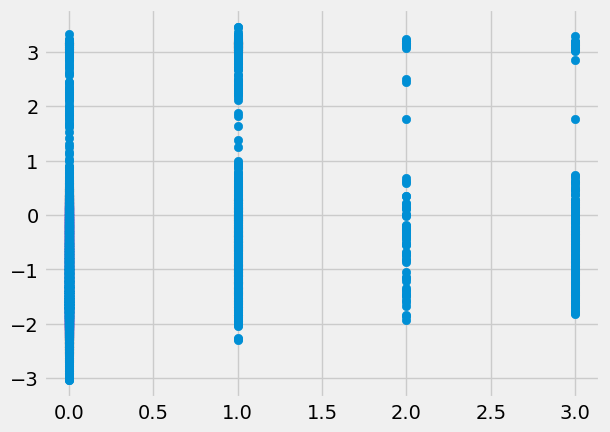

In [ ]:
test_predictions = ranker_model.predict(X_test_arr.astype(float))

y_test_df = pd.DataFrame({'relevance_score': y_test, 'predicted_ranking': test_predictions})

plt.style.use('fivethirtyeight')
plt.scatter(y_test_df["relevance_score"], y_test_df["predicted_ranking"])
plt.show()

In [ ]:
column_names = []
for i in [14,559,0,6,8,11,7,12,9,10]:
  column_names.append(X_train_2.columns[i])

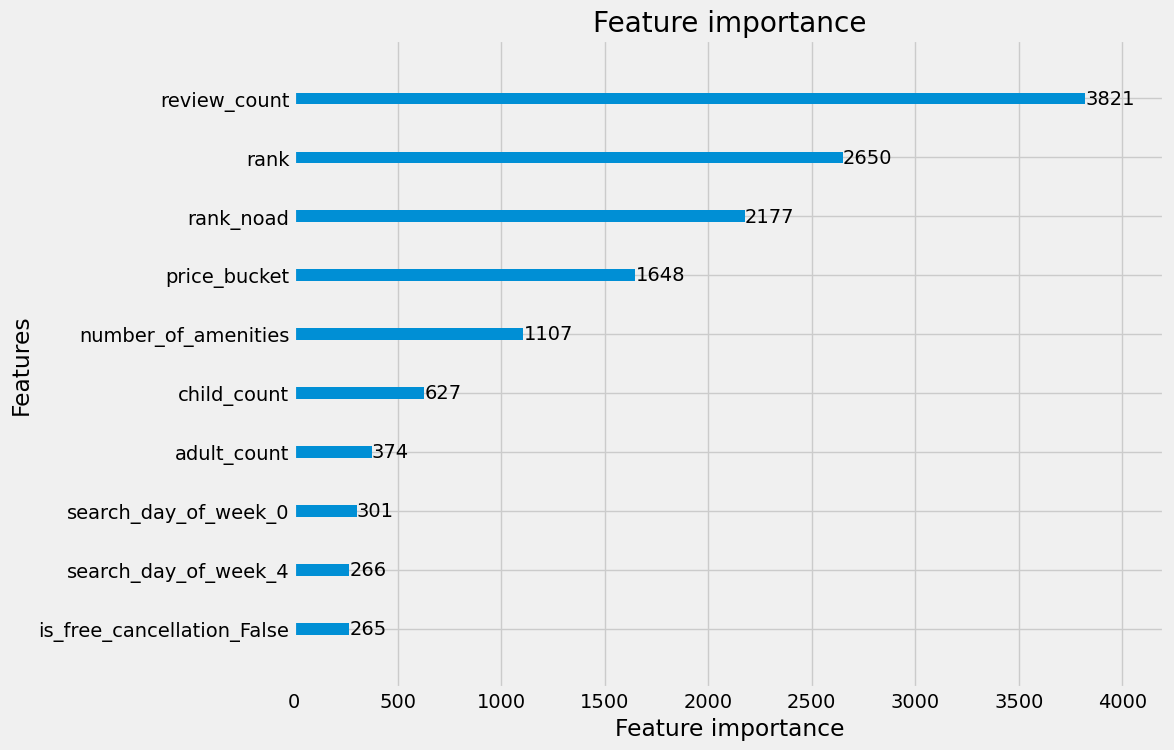

In [82]:
import matplotlib.pyplot as plt
import lightgbm as lgb

# Assuming ranker_model is your trained LightGBM model
fig, ax = plt.subplots(figsize=(10, 8))
plt.style.use('fivethirtyeight')
lgb.plot_importance(ranker_model, max_num_features=10, ax=ax)

# Extracting column numbers from the plot
column_numbers = [int(label.get_text().split('_')[-1]) for label in ax.get_yticklabels()]

# Assuming you're using X_train_2.columns to get column names
column_names = [X_train_2.columns[num] for num in column_numbers]

# Setting y-axis tick labels as column names
ax.set_yticklabels(column_names)

plt.show()


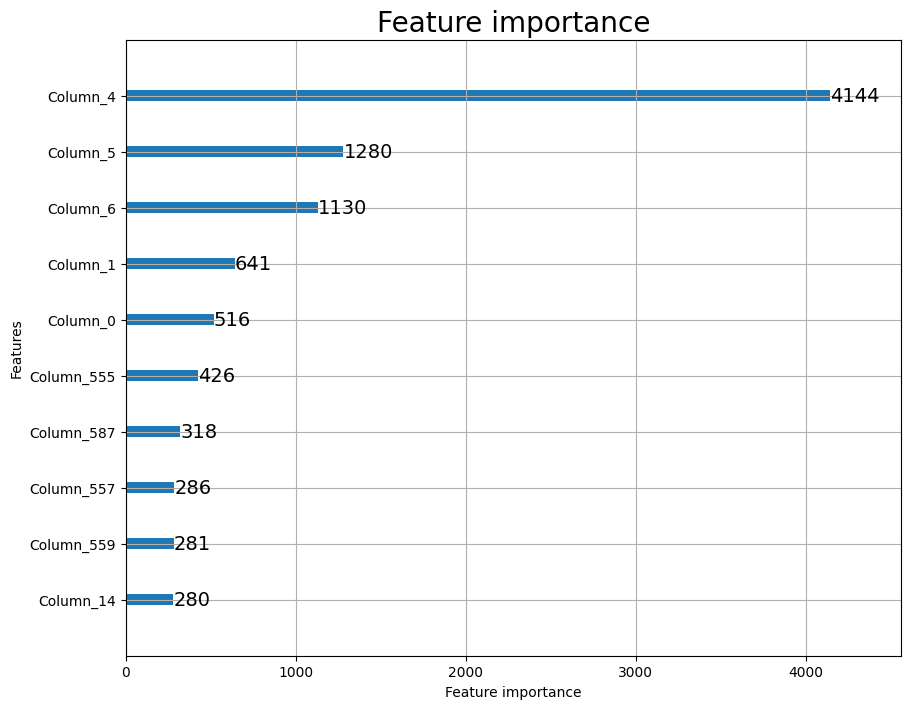

In [45]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.style.use('fivethirtyeight')
lgb.plot_importance(ranker_model, max_num_features=10, ax=ax)
#ax.set_yticklabels(column_names)
plt.show()

In [83]:
import numpy as np
from sklearn.metrics import ndcg_score

k_values = [1, 5, 10, 20, 30]

for k in k_values:
    ndcg_per_query = []
    for group_name, group_df in test_df.groupby('qid'):
        pred_scores = group_df['predicted_score']
        true_labels = sorted(group_df['relevance'], reverse=True)  # Assuming predicted scores are the same as true labels
        ndcg = ndcg_score([true_labels], [pred_scores], k=k)
        ndcg_per_query.append(ndcg)

    print(f'NDCG mean taking into account the first {k} values of the ranking:', np.mean(ndcg_per_query))


NDCG mean taking into account the first 1 values of the ranking: 0.03738156761412575
NDCG mean taking into account the first 5 values of the ranking: 0.061122367334154284
NDCG mean taking into account the first 10 values of the ranking: 0.07598110026964619
NDCG mean taking into account the first 20 values of the ranking: 0.16220025283263367
NDCG mean taking into account the first 30 values of the ranking: 0.29673281962744436


In [ ]:
# Define k values
k_values = [1, 5, 10, 20, 30]

# Initialize list to store NDCG means
ndcg_means = []

# Iterate over k_values
for k in k_values:
    # Initialize list to store NDCG values for each query
    ndcg_per_query = []

    # Iterate over groups in test_df
    for group_name, group_df in test_df.groupby('qid'):
        pred_scores = group_df['predicted_score']
        true_labels = sorted(group_df['relevance'], reverse=True)

        # Conditionally calculate NDCG for specified k or for all values
        if k == 'All':
            ndcg = ndcg_score([true_labels], [pred_scores])
        else:
            ndcg = ndcg_score([true_labels], [pred_scores], k=k)

        ndcg_per_query.append(ndcg)

    # Calculate mean NDCG for current k
    mean_ndcg = np.mean(ndcg_per_query)

    # Append mean NDCG to ndcg_means
    ndcg_means.append(mean_ndcg)

    # Print mean NDCG for current k
    if k == 'All':
        print(f'NDCG mean taking into account All values of the ranking:', mean_ndcg)
    else:
        print(f'NDCG mean taking into account the first {k} values of the ranking:', mean_ndcg)

NDCG mean taking into account the first 1 values of the ranking: 0.7813749000799362
NDCG mean taking into account the first 5 values of the ranking: 0.8309503677038552
NDCG mean taking into account the first 10 values of the ranking: 0.8580440022225648
NDCG mean taking into account the first 20 values of the ranking: 0.8643377918169929
NDCG mean taking into account the first 30 values of the ranking: 0.8646905302322566


In [ ]:
# Reorder k_values to ensure 'All' is at the end
k_values_reordered = k_values[:-1] + [k_values[-1]]

# Create the line plot
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=k_values_reordered,
    y=ndcg_means,
    mode='lines+markers',
    name='NDCG vs k'
))

# Update layout with FiveThirtyEight theme
fig.update_layout(
    template="plotly",
    xaxis=dict(
        title='Top k ranking positions',
        title_font=dict(size=28, color='black', family='Arial, bold'),
        tickfont=dict(size=24, color='black', family='Arial, bold'),
        dtick=5, range=[min(k_values_reordered)-1, max(k_values_reordered)]
    ),
    yaxis=dict(
        title='Mean NDCG Score',
        title_font=dict(size=28, color='black', family='Arial, bold'),
        tickfont=dict(size=24, color='black', family='Arial, bold')
    ),
    title='Mean NDCG across initial k ranking Values',
    title_font=dict(size=32, color='black', family='Arial, bold'),
    width=1000,
    height=600
)

fig.show()

# **Need to read code cells for loading amenities**

In [ ]:
df_amenities = pd.read_csv('/content/drive/MyDrive/Expedia/Data/amenities.tsv.gz', compression='gzip', sep='\t')

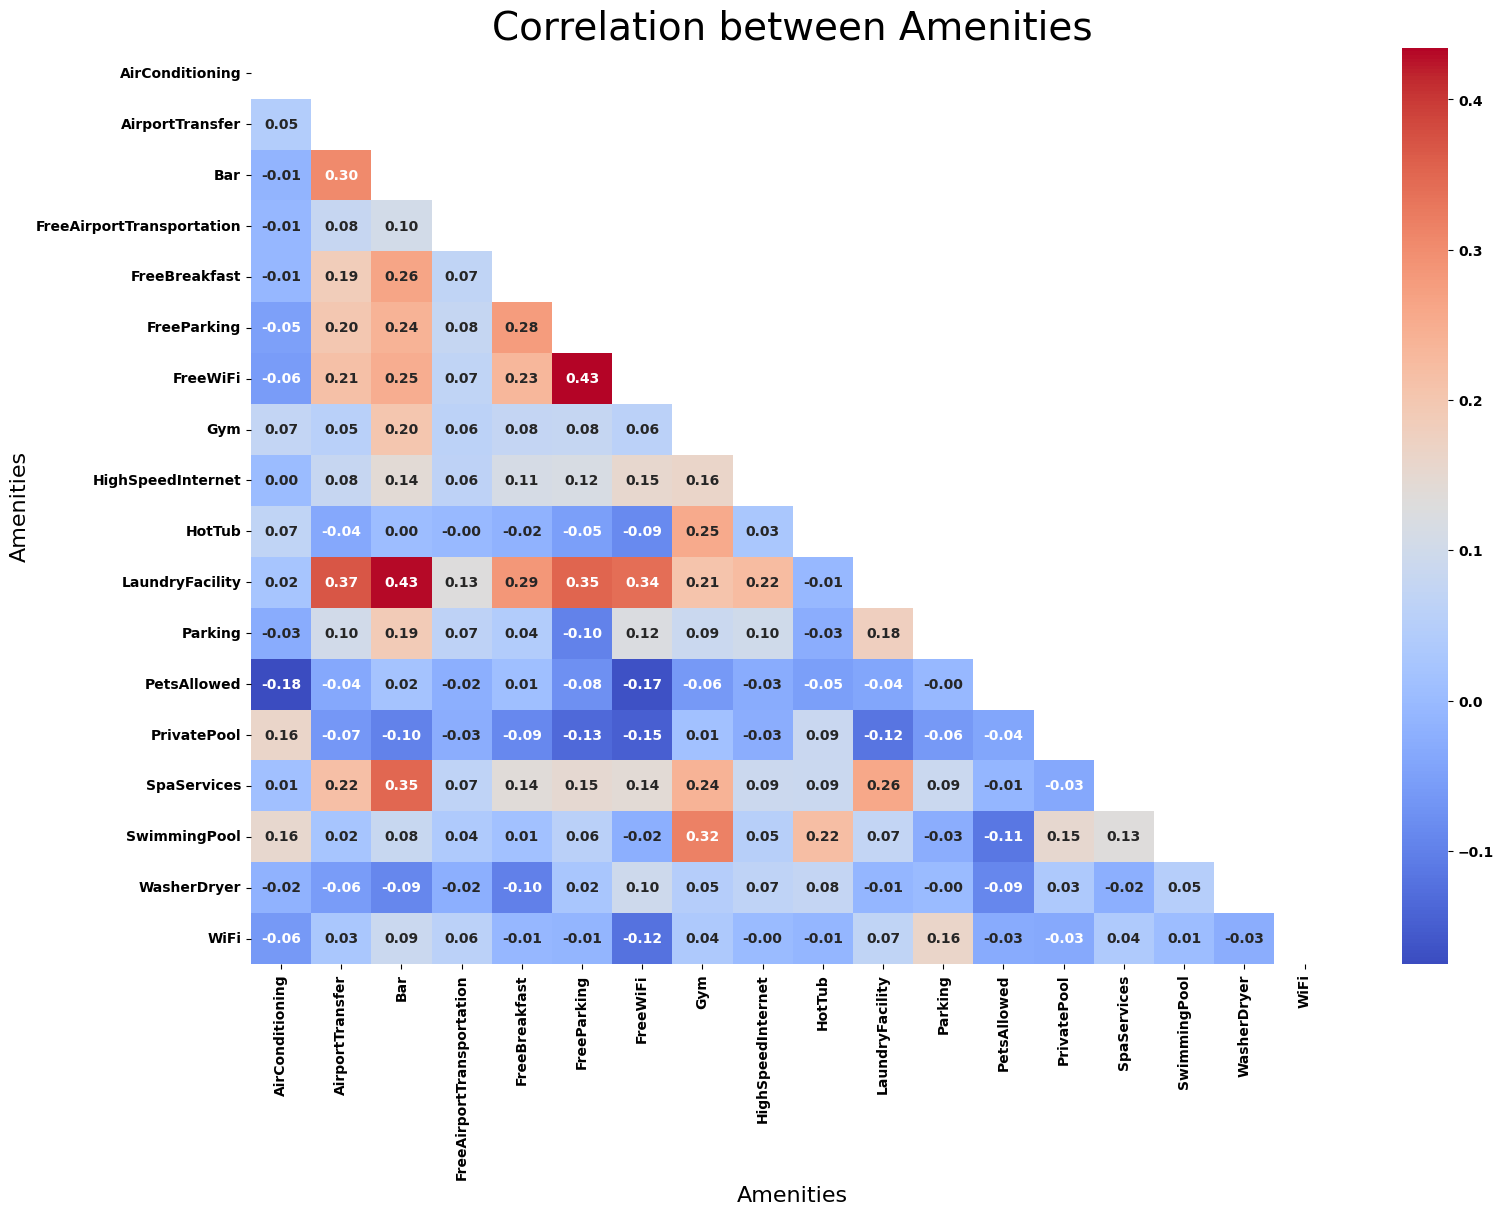

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Adjust font settings

amenities_correlation = df_amenities.drop('prop_id', axis=1).corr()

mask = np.triu(np.ones_like(amenities_correlation, dtype=bool))

plt.figure(figsize=(16, 12))

sns.heatmap(amenities_correlation, mask=mask, cmap='coolwarm', annot=True, fmt=".2f")

plt.title('Correlation between Amenities', fontdict={'size': 28, 'color': 'black'})
plt.tight_layout()

plt.xlabel('Amenities', fontdict={'size': 16, 'color': 'black'})
plt.ylabel('Amenities', fontdict={'size': 16, 'color': 'black'})


plt.show()



In [ ]:
df_amenities.columns

NameError: name 'df_amenities' is not defined

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Adjust font settings

amenities_correlation = df_amenities.drop('prop_id','FreeAirportTransportation','FreeWiFi' axis=1).corr()

mask = np.triu(np.ones_like(amenities_correlation, dtype=bool))

plt.figure(figsize=(16, 12))

sns.heatmap(amenities_correlation, mask=mask, cmap='coolwarm', annot=True, fmt=".2f")

plt.title('Correlation between Amenities', fontdict={'size': 28, 'color': 'black'})
plt.tight_layout()

plt.xlabel('Amenities', fontdict={'size': 16, 'color': 'black'})
plt.ylabel('Amenities', fontdict={'size': 16, 'color': 'black'})


plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set font family
plt.rcParams.update({'font.family': 'Arial'})

amenities_correlation = df_amenities.drop('prop_id', axis=1).corr()

mask = np.triu(np.ones_like(amenities_correlation, dtype=bool), k=1)  # Upper triangular mask

highlight_mask = (amenities_correlation > 0.2) | (amenities_correlation < -0.1)  # Highlight mask

plt.figure(figsize=(16, 12))

sns.heatmap(amenities_correlation, mask=mask | highlight_mask,
            cmap='coolwarm', annot=True, fmt=".2f", vmin=-0.2, vmax=0.45, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},
            annot_kws={"fontsize":16})

plt.title('Correlation between Amenities', fontsize=28, color='black')
plt.xlabel('Amenities', fontsize=16, color='black')
plt.ylabel('Amenities', fontsize=16, color='black')

plt.tight_layout()

plt.show()






In [ ]:
exploded_df_merged.columns

Index(['user_id', 'search_id', 'search_timestamp', 'point_of_sale',
       'geo_location_country', 'is_mobile', 'destination_id', 'adult_count',
       'child_count', 'infant_count', 'room_count', 'sort_type',
       'applied_filters', 'length_of_stay', 'booking_window', 'rank',
       'prop_id', 'is_travel_ad', 'review_rating', 'review_count',
       'star_rating', 'is_free_cancellation', 'is_drr', 'price_bucket',
       'num_clicks', 'is_trans', 'AirConditioning', 'AirportTransfer', 'Bar',
       'FreeAirportTransportation', 'FreeBreakfast', 'FreeParking', 'FreeWiFi',
       'Gym', 'HighSpeedInternet', 'HotTub', 'LaundryFacility', 'Parking',
       'PetsAllowed', 'PrivatePool', 'SpaServices', 'SwimmingPool',
       'WasherDryer', 'WiFi'],
      dtype='object')

In [ ]:
exploded_df_merged[['search_id','num_clicks']].groupby('search_id').agg({'num_clicks':'sum'})

,num_clicks
search_id,
0,6
1,0
2,1
3,0
4,0
...,...
99916,1
99917,0
99918,0


In [ ]:
non_clicked_properties_per_search = exploded_df_merged[['prop_id', 'num_clicks']].groupby('prop_id').agg({'num_clicks': lambda x: (x != 1).sum()}).reset_index()



In [ ]:
# Assuming non_clicked_properties_per_search is your DataFrame
zero_clicks_prop_ids = set(non_clicked_properties_per_search[non_clicked_properties_per_search['num_clicks'] == 0]['prop_id'])


In [ ]:
len(zero_clicks_prop_ids)

615

In [ ]:
exploded_df_merged.columns

Index(['user_id', 'search_id', 'search_timestamp', 'point_of_sale',
       'geo_location_country', 'is_mobile', 'destination_id', 'checkin_date',
       'checkout_date', 'adult_count', 'child_count', 'infant_count',
       'room_count', 'sort_type', 'applied_filters', 'impressions',
       'length_of_stay', 'booking_window', 'rank', 'prop_id', 'is_travel_ad',
       'review_rating', 'review_count', 'star_rating', 'is_free_cancellation',
       'is_drr', 'price_bucket', 'num_clicks', 'is_trans', 'AirConditioning',
       'AirportTransfer', 'Bar', 'FreeAirportTransportation', 'FreeBreakfast',
       'FreeParking', 'FreeWiFi', 'Gym', 'HighSpeedInternet', 'HotTub',
       'LaundryFacility', 'Parking', 'PetsAllowed', 'PrivatePool',
       'SpaServices', 'SwimmingPool', 'WasherDryer', 'WiFi'],
      dtype='object')

In [ ]:
exploded_df[['search_id','prop_id','num_clicks']]

In [ ]:
len(non_clicked_properties_per_search[non_clicked_properties_per_search['num_clicks']==0])

757204

In [ ]:
non_clicked_properties_per_search2 = (exploded_df_merged.groupby('prop_id')
                                     .agg(num_clicks=('num_clicks', 'sum'))).reset_index()



In [ ]:
exploded_df_merged.shape

(7107685, 47)

In [ ]:
# Grouping by 'prop_id' and aggregating 'ever_clicked' using the sum function
ever_clicked_counts = non_clicked_properties_per_search2.groupby('prop_id').agg(ever_clicked=('num_clicks', 'sum')).reset_index()

# Filtering out the rows where 'ever_clicked' is greater than 0
ever_clicked_counts_gt_zero = ever_clicked_counts[ever_clicked_counts['ever_clicked'] > 0]



In [ ]:
ever_clicked_counts_gt_zero

,prop_id,ever_clicked
9,90,1
79,662,1
94,783,1
120,1012,1
128,1072,1
...,...,...
779486,7039374,3
779493,7039448,1
779519,7039723,1
779592,7040373,1


In [ ]:
len(non_clicked_properties_per_search['prop_id'].value_counts())

779735

In [ ]:
import plotly.graph_objects as go


fig = go.Figure(data=[go.Histogram(x=non_clicked_properties_per_search['num_clicks'])])


fig.update_layout(
    title='Distribution of non-clicked properties per search',
    title_font=dict(size=28, color='black', family='Arial, bold'),
    xaxis=dict(
        title='Number of non-clicked properties',
        title_font=dict(size=24, color='black', family='Arial, bold'),
        tickfont=dict(size=20, color='black', family='Arial, bold'),
        range=[-1, 41]
    ),
    yaxis=dict(
        title='Frequency',
        title_font=dict(size=24, color='black', family='Arial, bold'),
        tickfont=dict(size=20, color='black', family='Arial, bold')
    )
)

fig.show()


In [ ]:
filtered_df = exploded_df_merged[~exploded_df_merged['search_id'].isin(exploded_df_merged.groupby('search_id')['num_clicks'].sum()[lambda x: x == 0].index)]

In [ ]:
exploded_df_merged.shape

(7107685, 47)

In [ ]:
filtered_df[['search_id','num_clicks']].groupby('search_id').agg({'num_clicks':'sum'})

,num_clicks
search_id,
0,6
2,1
10,2
15,1
19,2
...,...
99879,2
99880,1
99901,1


In [ ]:
exploded_df_merged.head()

,user_id,search_id,search_timestamp,point_of_sale,geo_location_country,is_mobile,destination_id,checkin_date,checkout_date,adult_count,...,HighSpeedInternet,HotTub,LaundryFacility,Parking,PetsAllowed,PrivatePool,SpaServices,SwimmingPool,WasherDryer,WiFi
0,001bbff3030c95740d4c55bb72e823e9,541933a931216d270f53277c2de068d0,2021-07-02T19:38:00.000Z,2,1,0,898,2021-07-04,2021-07-05,2,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,001bbff3030c95740d4c55bb72e823e9,541933a931216d270f53277c2de068d0,2021-07-02T19:38:00.000Z,2,1,0,898,2021-07-04,2021-07-05,2,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,001bbff3030c95740d4c55bb72e823e9,541933a931216d270f53277c2de068d0,2021-07-02T19:38:00.000Z,2,1,0,898,2021-07-04,2021-07-05,2,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,001bbff3030c95740d4c55bb72e823e9,541933a931216d270f53277c2de068d0,2021-07-02T19:38:00.000Z,2,1,0,898,2021-07-04,2021-07-05,2,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,001bbff3030c95740d4c55bb72e823e9,541933a931216d270f53277c2de068d0,2021-07-02T19:38:00.000Z,2,1,0,898,2021-07-04,2021-07-05,2,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
#file_path = '/content/drive/My Drive/Expedia/Data/exploded_df_merged_amenities_100Krows_Exploded_to_7Million.csv'
#exploded_df_merged.to_parquet('/content/drive/My Drive/Expedia/Data/exploded_df_merged_100Krows_7Million.parquet', index=False)

exploded_df_merged=pd.read_parquet('/content/drive/My Drive/Expedia/Data/exploded_df_merged_100Krows_7Million.parquet')

#exploded_df_merged.to_csv(file_path, index=False)

#exploded_df_GM=pd.read_csv("/content/drive/My Drive/Expedia/Data/exploded_df_merged_amenities.csv", sep=',')


In [ ]:
filtered_df = exploded_df_merged[~exploded_df_merged['search_id'].isin(exploded_df_merged.groupby('search_id')['num_clicks'].sum()[lambda x: x == 0].index)]

In [ ]:
filtered_df.shape

(1427812, 47)

In [ ]:
import plotly.graph_objects as go

# Assuming filtered_df contains the DataFrame and 'num_clicks' is the column name
#histogram_data = filtered_df.groupby('search_id').agg({'num_clicks':'sum'})

fig = go.Figure(data=[go.Histogram(x=filtered_df.groupby('search_id').agg({'num_clicks':'sum'})['num_clicks'])])

fig.update_layout(
    title='Distribution of number of clicks per search ',
    title_font=dict(size=28, color='black', family='Arial, bold'),
    xaxis=dict(
        title='Number of clicks',
        title_font=dict(size=24, color='black', family='Arial, bold'),
        tickfont=dict(size=20, color='black', family='Arial, bold'),
        range=[0, 10]
    ),
    yaxis=dict(
        title='Frequency',
        title_font=dict(size=24, color='black', family='Arial, bold'),
        tickfont=dict(size=20, color='black', family='Arial, bold')
    )
)

fig.show()


In [ ]:
import plotly.graph_objects as go

# Assuming filtered_df contains the DataFrame and 'num_clicks' is the column name
# histogram_data = filtered_df.groupby('search_id').agg({'num_clicks':'sum'})

fig = go.Figure(data=[go.Histogram(x=filtered_df.groupby('search_id').agg({'num_clicks':'sum'})['num_clicks'])])

fig.update_layout(
    title='Distribution of number of clicks per search',
    title_font=dict(size=32, color='black', family='Arial, bold'),
    xaxis=dict(
        title='Number of clicks',
        title_font=dict(size=28, color='black', family='Arial, bold'),
        tickfont=dict(size=24, color='black', family='Arial, bold'),
        dtick=1,  # Set the interval between tick marks on the x-axis to 10
        range=[0, 10],

    ),
    yaxis=dict(
        title='Frequency',
        title_font=dict(size=28, color='black', family='Arial, bold'),
        tickfont=dict(size=24, color='black', family='Arial, bold'),

    ),
    bargap=0.1,  # Adjust the gap between bars
    bargroupgap=0.1,  # Adjust the gap between groups of bars
    width=1000,  # Set the width of the figure
    height=600  # Set the height of the figure
)

fig.show()


In [ ]:
exploded_df_merged

In [ ]:
sampled_df = exploded_df_merged.sample(frac=0.5, random_state=42)
sampled_df_applied_filters=sampled_df['applied_filters']
sampled_df_applied_filters.shape

(3553842,)

In [ ]:
df_applied_filters_expanded = sampled_df_applied_filters.str.get_dummies(sep='|')

In [ ]:
df_applied_filters_expanded.shape

(3553842, 147)

In [ ]:
# LODGING is removed right now to reduce number of columns while one hot encoding
applied_filter_column_removal=['AMENITY','LANDMARK','POI','PRICE','HOTEL_ID','PROPERTYNAME','HOTEL_NAME','NEIGHBOURHOOD','LODGING']

columns_to_remove = [col for col in df_applied_filters_expanded.columns if any(keyword in col for keyword in applied_filter_column_removal)]
df_applied_filters_expanded.drop(columns=columns_to_remove, inplace=True)


In [ ]:
sampled_df['applied_filters'].unique()

array([nan, 'VIPONLY:FALSE', 'VIPONLY:FALSE|PAYMENTTYPE:PAY_LATER', ...,
       'LODGING:APARTMENT|LODGING:CHALET|LODGING:CONDO|LODGING:COTTAGE|LODGING:HOUSEBOAT|LODGING:VILLA|LODGING:VACATIONHOME',
       'STAR:3.0|STAR:4.0|STAR:5.0|LODGING:APARTMENT|LODGING:APARTHOTEL|REVIEWSCORE:',
       'LODGING:HOTELRESORT|POI:XXX|REVIEWSCORE:4.0:5.0'], dtype=object)

In [ ]:
# Count the number of filters in each row
filter_counts = exploded_df['applied_filters'].str.count('|') + 1

# Filter the DataFrame for rows where the number of filters is >= 80
filtered_df = exploded_df[filter_counts >= 80].index

filtered_df




Index([17987, 17988, 17989, 17990, 17991, 17992, 17993, 17994, 17995, 17996,
       ...
       67113, 67114, 67115, 67116, 67117, 67118, 67119, 67120, 67121, 67122],
      dtype='int64', length=600)

In [ ]:
exploded_df.iloc[17987]['applied_filters'].split('|')

['LODGING:APARTMENT',
 'LODGING:CABIN',
 'LODGING:CHALET',
 'LODGING:CONDO',
 'LODGING:COTTAGE',
 'LODGING:HOUSEBOAT',
 'LODGING:VILLA',
 'LODGING:VACATIONHOME']

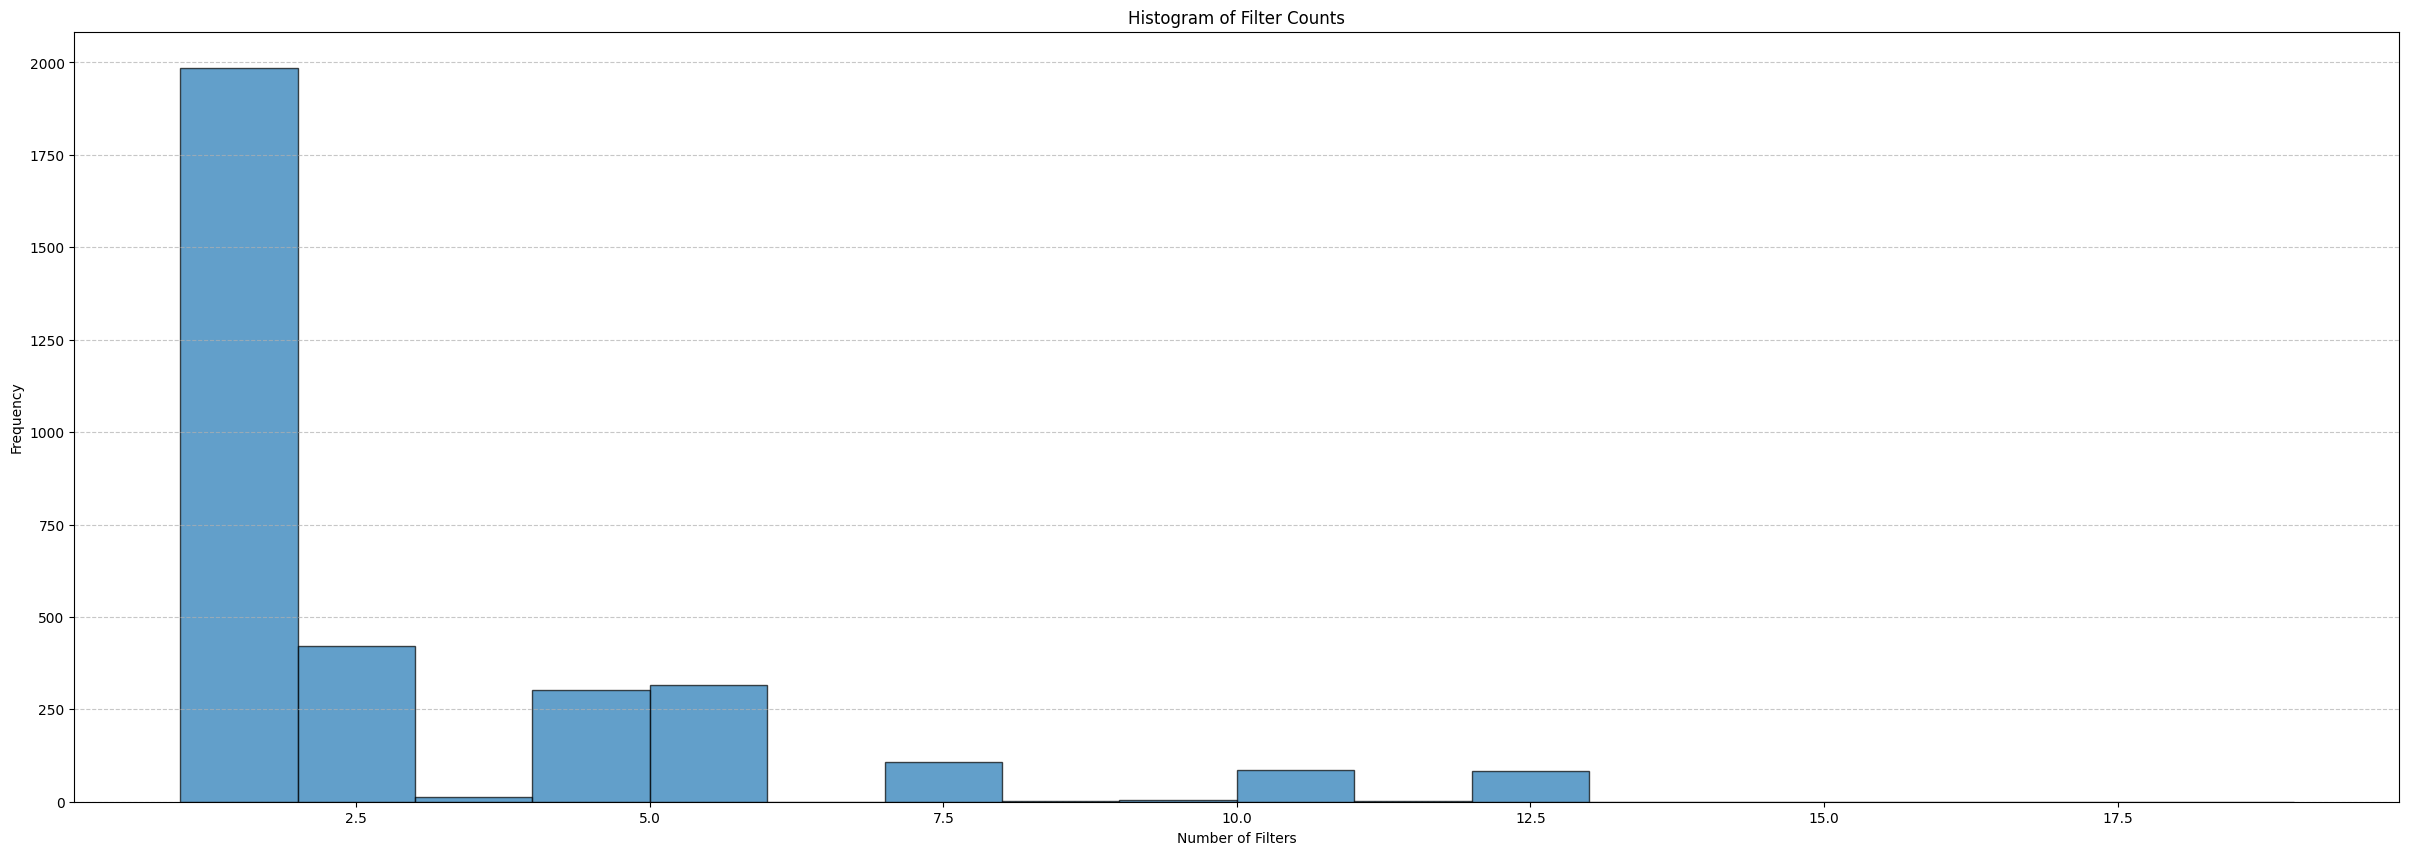

In [ ]:
# exploded_df[~exploded_df['applied_filters'].isna()]['applied_filters'] # display only rows with applied filters
#filter_counts = (exploded_df[~exploded_df['applied_filters'].isna()]['applied_filters'].str.count('|') + 1).astype(int)
filter_counts = exploded_df['applied_filters'].str.count('\|')

# Plot histogram
plt.figure(figsize=(30, 10))
plt.hist(filter_counts, np.arange(1, 20, 1), edgecolor='black', alpha=0.7)
plt.xlabel('Number of Filters')
plt.ylabel('Frequency')
plt.title('Histogram of Filter Counts')
#plt.xticks(range(1, filter_counts.max() + 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:

exploded_df['applied_filters'][:10].unique()

array([nan, 'VIPONLY:FALSE', 'PRICE:0', 'MEALPLAN:ALL_INCLUSIVE',
       'AMENITY:7', 'PROPERTYNAME:XXX|MEALPLAN:FREE_BREAKFAST',
       'MEALPLAN:FREE_BREAKFAST', 'STAR:4.0', 'AMENITY:72', 'AMENITY:71',
       'STAR:3.0|STAR:4.0|STAR:5.0|LODGING:HOTEL|MEALPLAN:FREE_BREAKFAST|REVIEWSCORE:',
       'AMENITY:72|STAR:3.0|STAR:4.0|STAR:5.0|LODGING:CONDO',
       'AMENITY:72|STAR:3.0|STAR:4.0|STAR:5.0|LODGING:HOTEL|MEALPLAN:FREE_BREAKFAST',
       'STAR:3.0|STAR:4.0', 'STAR:4.0|STAR:5.0', 'STAR:5.0', 'AMENITY:66',
       'AMENITY:66|REVIEWSCORE:', 'AMENITY:14|AMENITY:19',
       'AMENITY:19|AMENITY:14|MEALPLAN:ALL_INCLUSIVE',
       'AMENITY:19|AMENITY:14', 'AMENITY:19|AMENITY:14|AMENITY:72',
       'LODGING:APARTMENT|LODGING:CABIN|LODGING:CHALET|LODGING:CONDO|LODGING:COTTAGE|LODGING:HOUSEBOAT|LODGING:VILLA|LODGING:VACATIONHOME',
       'LODGING:VILLA|LODGING:COTTAGE|LODGING:APARTMENT|LODGING:CABIN|LODGING:HOUSEBOAT|LODGING:VACATIONHOME|LODGING:CHALET|LODGING:CONDO|REVIEWSCORE:4.0:5.0',
   

In [ ]:

# Assuming your DataFrame is named df and the column containing filters is named 'applied_filters'
#filters_exploded_df = exploded_df.assign(applied_filters=exploded_df['applied_filters'].str.split('|')).explode('applied_filters')

filters_exploded_df = exploded_df['applied_filters'].str.split('|').explode('applied_filters')




In [ ]:
filters_exploded_df.head()


0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
Name: applied_filters, dtype: object

In [ ]:
exploded_df_merged.head()

,user_id,search_id,search_timestamp,point_of_sale,geo_location_country,is_mobile,destination_id,checkin_date,checkout_date,adult_count,...,HighSpeedInternet,HotTub,LaundryFacility,Parking,PetsAllowed,PrivatePool,SpaServices,SwimmingPool,WasherDryer,WiFi
0,001bbff3030c95740d4c55bb72e823e9,541933a931216d270f53277c2de068d0,2021-07-02T19:38:00.000Z,2,1,0,898,2021-07-04,2021-07-05,2,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,001bbff3030c95740d4c55bb72e823e9,541933a931216d270f53277c2de068d0,2021-07-02T19:38:00.000Z,2,1,0,898,2021-07-04,2021-07-05,2,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,001bbff3030c95740d4c55bb72e823e9,541933a931216d270f53277c2de068d0,2021-07-02T19:38:00.000Z,2,1,0,898,2021-07-04,2021-07-05,2,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,001bbff3030c95740d4c55bb72e823e9,541933a931216d270f53277c2de068d0,2021-07-02T19:38:00.000Z,2,1,0,898,2021-07-04,2021-07-05,2,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,001bbff3030c95740d4c55bb72e823e9,541933a931216d270f53277c2de068d0,2021-07-02T19:38:00.000Z,2,1,0,898,2021-07-04,2021-07-05,2,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


#SOME VISUALIZATIONS

In [ ]:
exploded_df_merged[['rank','num_clicks']].head()

,rank,num_clicks
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [ ]:
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
from tqdm import tqdm

# Convert pandas DataFrame to dask DataFrame
dask_df = dd.from_pandas(exploded_df_merged[['rank', 'num_clicks']], npartitions=4)

# Use groupby and sum with tqdm progress bar
with ProgressBar():
    count_rank = dask_df.groupby('rank').agg({'num_clicks':'sum'}).compute()



[########################################] | 100% Completed | 102.85 ms


In [ ]:
count_rank

,num_clicks
rank,
1,9612
2,3313
3,2545
4,1939
5,1666
...,...
96,45
97,41
98,43


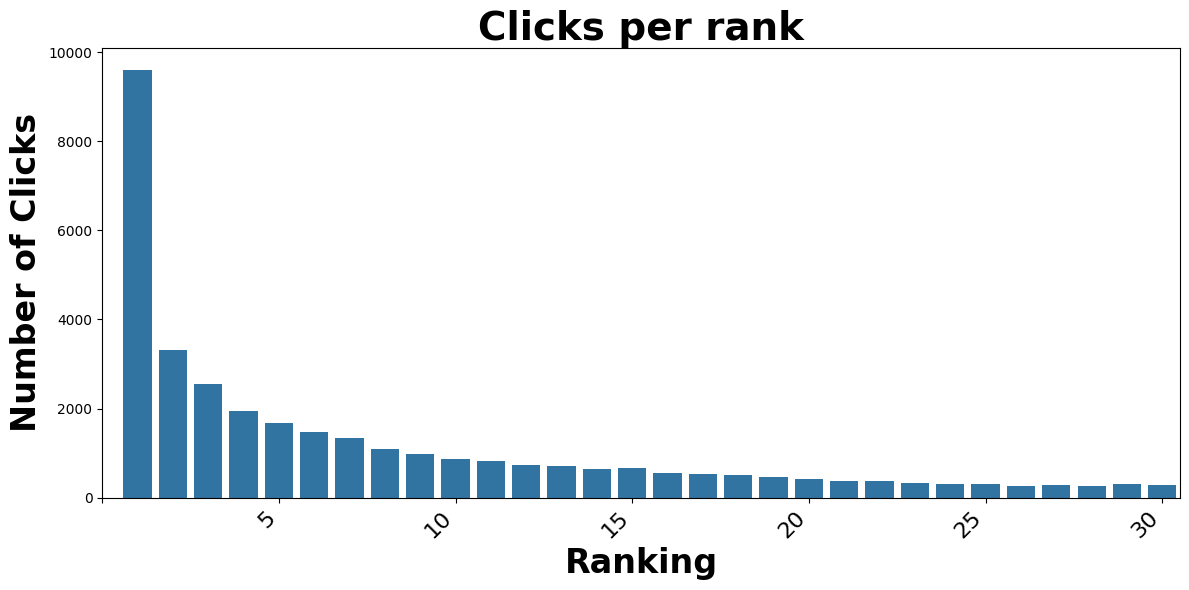

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
# Ensure the data is limited to the first 50 rankings
# Assuming 'count_rank' is a series or DataFrame column with an index that goes beyond 50.

sns.barplot(x='rank', y='num_clicks', data=count_rank.iloc[0:30])

# Set ticks from 0 to 50, increment by 5
n = 5
plt.xticks(range(-1, 30, n), rotation=45, ha='right', fontsize=16, color='black')
plt.title('Clicks per rank', fontdict={'size': 28, 'color': 'black', 'family': 'Arial', 'weight': 'bold'})
plt.xlabel('Ranking', fontdict={'size': 24, 'color': 'black', 'family': 'Arial', 'weight': 'bold'})
plt.ylabel('Number of Clicks', fontdict={'size': 24, 'color': 'black', 'family': 'Arial', 'weight': 'bold'})

plt.tight_layout()
plt.show()




In [ ]:
# Convert pandas DataFrame to dask DataFrame
dask_df = dd.from_pandas(exploded_df_merged[['rank', 'is_trans']], npartitions=4)

# Use groupby and sum with tqdm progress bar
with ProgressBar():
    book_rank = dask_df.groupby('rank').agg({'is_trans':'sum'}).compute()

[########################################] | 100% Completed | 103.62 ms


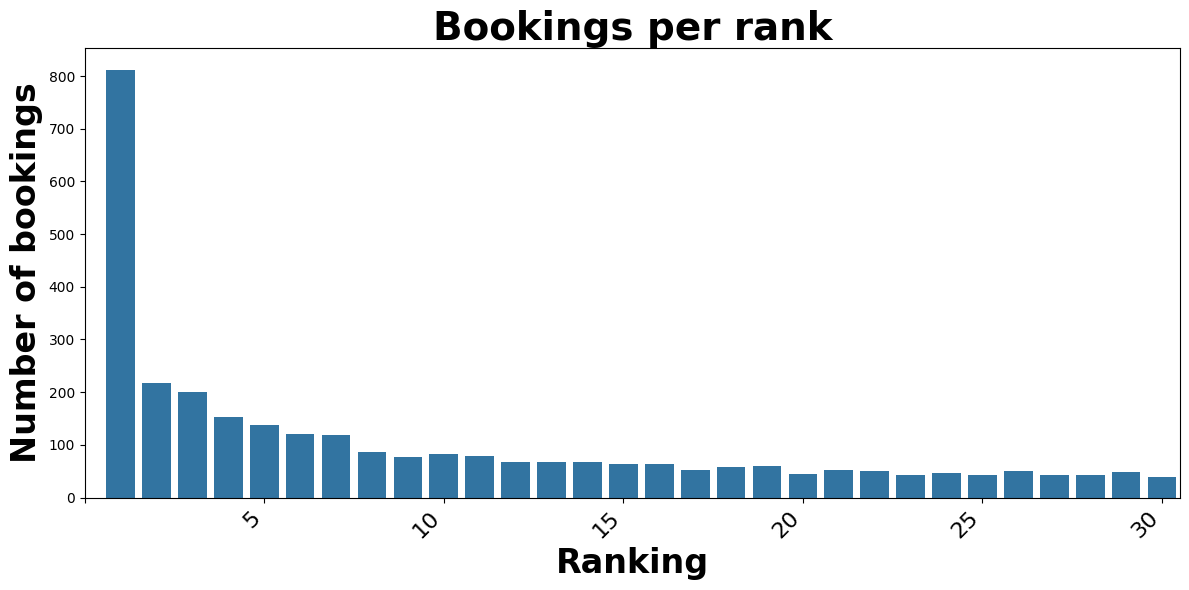

In [ ]:
plt.figure(figsize=(12, 6))
# Ensure the data is limited to the first 50 rankings
# Assuming 'count_rank' is a series or DataFrame column with an index that goes beyond 50.

sns.barplot(x='rank', y='is_trans', data=book_rank.iloc[0:30])

# Set ticks from 0 to 50, increment by 5
n = 5
plt.xticks(range(-1, 30, n), rotation=45, ha='right', fontsize=16, color='black')
plt.title('Bookings per rank', fontdict={'size': 28, 'color': 'black', 'family': 'Arial', 'weight': 'bold'})
plt.xlabel('Ranking', fontdict={'size': 24, 'color': 'black', 'family': 'Arial', 'weight': 'bold'})
plt.ylabel('Number of bookings', fontdict={'size': 24, 'color': 'black', 'family': 'Arial', 'weight': 'bold'})

plt.tight_layout()
plt.show()


In [ ]:
import dask.dataframe as dd  # Import the dask dataframe module
from dask.diagnostics import ProgressBar
dask_df = dd.from_pandas(exploded_df_merged[['num_clicks', 'is_trans', 'review_rating']], npartitions=4)
with ProgressBar():
    review_clicks = dask_df.groupby('review_rating').agg({'num_clicks':'sum'}).compute()





[########################################] | 100% Completed | 205.06 ms


In [ ]:
with ProgressBar():
    review_trans = dask_df.groupby('review_rating').agg({'is_trans':'sum'}).compute()

[########################################] | 100% Completed | 102.39 ms


In [ ]:
review_merged=review_clicks.merge(review_trans, on='review_rating')

In [ ]:
import plotly.graph_objs as go
import plotly.io as pio

# Define data from review_merged
review_rating = review_merged.index
review_clicks = review_merged['num_clicks']
review_trans = review_merged['is_trans']

# Create grouped bar plot
trace1 = go.Bar(
    x=review_rating,
    y=review_clicks,
    name='Clicked'
)
trace2 = go.Bar(
    x=review_rating,
    y=review_trans,
    name='Booked'
)

data = [trace1, trace2]
layout = go.Layout(
    title='Having no review rating is still better than lower review rating',
    titlefont=dict(size=32, color='black', family='Arial'),  # Title font properties
    xaxis=dict(title='Review rating', titlefont=dict(size=28, color='black', family='Arial'),
               tickfont=dict(size=24)),  # X-axis title, tick, and font properties
    yaxis=dict(title='Number of clicks / bookings', titlefont=dict(size=28, color='black', family='Arial'),
               tickfont=dict(size=24)),  # Y-axis title, tick, and font properties
    barmode='group',  # Set barmode to 'group' for grouped bars
    bargap=0.001,  # Reduce spacing between bars
    legend=dict(orientation="h", x=0.05, y=0.95, font=dict(size=24)),
    #plot_bgcolor='rgba(0,0,0,0)'  # Set plot background color to transparent
    width=1000,  # Set the width of the figure
    height=600  # Set the height of the figure
)


fig = go.Figure(data=data, layout=layout)

# Show the plot
pio.show(fig)
